In [ ]:
import sys
import os
# Add the RQ1 directory to the path
sys.path.append(os.path.abspath("../"))
from classification import WordNonwordClassifier

# model_name = "Tower-Babel/Babel-9B-Chat"
model_name = "google/gemma-3-12b-it"
# model_name = "google/gemma-3-12b-pt"
# model_name = "meta-llama/Llama-2-7b-chat-hf"
word_nonword_cls = WordNonwordClassifier("English", model_name) # language is not used in the model name, but it is required by the class

Using device: cuda


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def prepare_dataset(lang1, lang2):
    dataset_en_ko = load_dataset("tatoeba", lang1=lang1, lang2=lang2)
    dataset_en_ko = dataset_en_ko['train'].to_pandas()
    dataset_en_ko[lang1] = dataset_en_ko['translation'].str[lang1]
    dataset_en_ko[lang2] = dataset_en_ko['translation'].str[lang2]
    dataset_en_ko = dataset_en_ko[[lang1, lang2]]
    dataset_en_ko = dataset_en_ko[dataset_en_ko[lang1].str.len() >= 3]
    dataset_en_ko = dataset_en_ko[dataset_en_ko[lang2].str.len() >= 3]
    dataset_en_ko = dataset_en_ko.sample(n=1000, random_state=2025).reset_index(drop=True)
    dataset_en_ko[f'{lang1}_tokens'] = dataset_en_ko[lang1].apply(word_nonword_cls.tokenizer.tokenize)
    dataset_en_ko[f'{lang2}_tokens'] = dataset_en_ko[lang2].apply(word_nonword_cls.tokenizer.tokenize)
    return dataset_en_ko

def compute_crosslingual_cosine(hidden_en, hidden_ko, top_k=5):
    results = {}

    for layer in hidden_en:
        en_vecs = hidden_en[layer]  # shape: (N, D)
        ko_vecs = hidden_ko[layer]  # shape: (N, D)

        # Normalize to unit vectors for cosine similarity
        en_norm = F.normalize(en_vecs, p=2, dim=1)  # (N, D)
        ko_norm = F.normalize(ko_vecs, p=2, dim=1)  # (N, D)

        # Compute cosine similarity: (N x D) @ (D x N) = (N x N)
        global sim_matrix
        sim_matrix = en_norm @ ko_norm.T  # (N, N)

        # For each English vector, get top-k most similar Korean vectors
        topk_values, topk_indices = torch.topk(sim_matrix, k=top_k, dim=1)  # (N, top_k)
        
        # Check if correct alignment exists in top-k (optional accuracy check)
        correct = torch.arange(sim_matrix.size(0)).to(topk_indices.device)
        hits = (topk_indices == correct.unsqueeze(1)).any(dim=1).float()  # 1 if correct in top-k

        results[layer] = {
            "similarity_matrix": sim_matrix,
            "topk_indices": topk_indices,
            "topk_values": topk_values,
            "topk_accuracy": hits.mean().item(),  # overall top-k accuracy
        }

    return results

In [ ]:
lang1 = "en"
lang2 = "ko"

dataset_en_ko = prepare_dataset(lang1, lang2)

hidden_1 = word_nonword_cls.extract_token_i_hidden_states(dataset_en_ko[f'{lang1}_tokens'].tolist())
hidden_2 = word_nonword_cls.extract_token_i_hidden_states(dataset_en_ko[f'{lang2}_tokens'].tolist())
torch.save(hidden_1, f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang1}_1.pt")
torch.save(hidden_2, f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang2}_1.pt")

top_k = 3
results = compute_crosslingual_cosine(hidden_1, hidden_2, top_k=top_k)

layers = sorted(results.keys())
accuracies = [results[l]['topk_accuracy'] for l in layers]
plt.plot(layers, accuracies)
plt.xlabel("Layer")
plt.ylabel(f"Top-{top_k} Accuracy")
plt.title(f"Cross-Lingual Alignment over Layers ({lang1}-{lang2})")
plt.grid(True)
plt.show()

NameError: name 'prepare_dataset' is not defined

: 

Extracting hidden states: 100%|██████████| 1000/1000 [01:53<00:00,  8.81it/s]


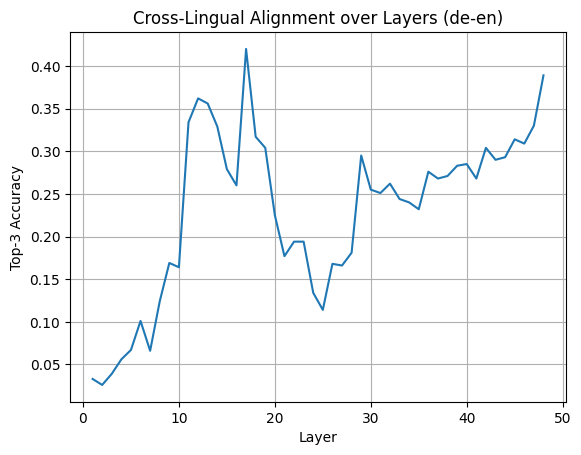

In [4]:
lang1 = "de"
lang2 = "en"

dataset_de_en = prepare_dataset(lang1, lang2)

hidden_1 = word_nonword_cls.extract_token_i_hidden_states(dataset_de_en[f'{lang1}_tokens'].tolist())
hidden_2 = word_nonword_cls.extract_token_i_hidden_states(dataset_de_en[f'{lang2}_tokens'].tolist())

top_k = 3
results = compute_crosslingual_cosine(hidden_1, hidden_2, top_k=top_k)

layers = sorted(results.keys())
accuracies = [results[l]['topk_accuracy'] for l in layers]
plt.plot(layers, accuracies)
plt.xlabel("Layer")
plt.ylabel(f"Top-{top_k} Accuracy")
plt.title(f"Cross-Lingual Alignment over Layers ({lang1}-{lang2})")
plt.grid(True)
plt.show()

Extracting hidden states: 100%|██████████| 1000/1000 [01:55<00:00,  8.67it/s]


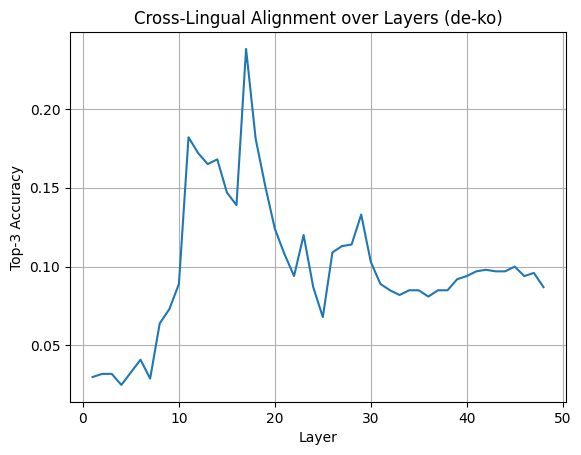

In [6]:
lang1 = "de"
lang2 = "ko"

dataset_de_ko = prepare_dataset(lang1, lang2)

hidden_1 = word_nonword_cls.extract_token_i_hidden_states(dataset_de_ko[f'{lang1}_tokens'].tolist())
hidden_2 = word_nonword_cls.extract_token_i_hidden_states(dataset_de_ko[f'{lang2}_tokens'].tolist())

top_k = 3
results = compute_crosslingual_cosine(hidden_1, hidden_2, top_k=top_k)

layers = sorted(results.keys())
accuracies = [results[l]['topk_accuracy'] for l in layers]
plt.plot(layers, accuracies)
plt.xlabel("Layer")
plt.ylabel(f"Top-{top_k} Accuracy")
plt.title(f"Cross-Lingual Alignment over Layers ({lang1}-{lang2})")
plt.grid(True)
plt.show()